In [191]:
"""VOC Dataset Classes
Original author: Francisco Massa
https://github.com/fmassa/vision/blob/voc_dataset/torchvision/datasets/voc.py
Updated by: Ellis Brown, Max deGroot
"""
import os
# from .config import HOME
import os.path as osp
import sys
import torch
import torch.utils.data as data
import cv2
import numpy as np
import random
if sys.version_info[0] == 2:
    import xml.etree.cElementTree as ET
else:
    import xml.etree.ElementTree as ET
    
import torchvision.transforms as transforms
    
VOC_CLASSES = (  # always index 0
    'fire',
'smoke',
'person',
'firefighter'
)

# note: if you used our download scripts, this should be right
#DATA_ROOT = osp.join(HOME, "data/fire/")

####### 
# VOC_ROOT = osp.join(HOME, "data/fire/")
# DATA_ROOT = osp.join(HOME, "data/fire/")

# VOC_ROOT = osp.join("./", "data/")
# DATA_ROOT = osp.join("./", "data")

class VOCAnnotationTransform_con(object):
    """Transforms a VOC annotation into a Tensor of bbox coords and label index
    Initilized with a dictionary lookup of classnames to indexes
    Arguments:
        class_to_ind (dict, optional): dictionary lookup of classnames -> indexes
            (default: alphabetic indexing of VOC's 20 classes)
        keep_difficult (bool, optional): keep difficult instances or not
            (default: False)
        height (int): height
        width (int): width
    """

    def __init__(self, class_to_ind=None, keep_difficult=False):
        self.class_to_ind = class_to_ind or dict(
            zip(VOC_CLASSES, range(len(VOC_CLASSES))))
        self.keep_difficult = keep_difficult

    def __call__(self, target, width, height):
        """
        Arguments:
            target (annotation) : the target annotation to be made usable
                will be an ET.Element
        Returns:
            a list containing lists of bounding boxes  [bbox coords, class name]
        """
        res = []
        for obj in target.iter('object'):
            difficult = int(obj.find('difficult').text) == 1
            if not self.keep_difficult and difficult:
                continue
            name = obj.find('name').text.lower().strip()
            bbox = obj.find('bndbox')

            pts = ['xmin', 'ymin', 'xmax', 'ymax']
            bndbox = []
            for i, pt in enumerate(pts):
                cur_pt = int(bbox.find(pt).text) - 1
                # scale height or width
                cur_pt = cur_pt / width if i % 2 == 0 else cur_pt / height
                bndbox.append(cur_pt)
            #print(name)
            if name not in VOC_CLASSES:
                print(name)
            
            label_idx = self.class_to_ind[name]
            bndbox.append(label_idx)
            res += [bndbox]  # [xmin, ymin, xmax, ymax, label_ind]
            # img_id = target.find('filename').text[:-4]
            
        #if res == []:
        #    print('errrrrrrrr')

        return res  # [[xmin, ymin, xmax, ymax, label_ind], ... ]


class Firehouse_dataset(data.Dataset):

    def __init__(self,root,dataset_type = "VOC", transform = None):
        self.root = root
        
        ## HOME ROOT
#         self.root = HOME
        self.dataset_type = dataset_type
        DATA_ROOT = osp.join(root, 'data/fire/')
        

        ##self.image_set = image_sets
        self.voc_transform = transform
        self.voc_target_transform = VOCAnnotationTransform_con()        
        self.yolo_target_transform = self.VOC_2_YOLO_AnnotationTransform_con
        
        self._annopath = osp.join(DATA_ROOT, 'annotations', '%s.xml')
    #     self.image_dir = osp.join(DATA_ROOT, 'images/')
        self.annopath_dir = osp.join(DATA_ROOT, 'annotations/')
        self.labeled_dir = osp.join(DATA_ROOT, 'labeled_img/')
        self.unlabeled_dir = osp.join(DATA_ROOT, 'unlabeled_img/')


        self.annotation_ids = os.listdir(self.annopath_dir)
        self.labeled_ids = os.listdir(self.labeled_dir)
        self.unlabeled_ids = os.listdir(self.unlabeled_dir)

    def __getitem__(self,index):
    
    ## img = np
        
        _,img, gt, h, w, semi = self.pull_voc_item(index , transform = self.voc_transform)
        if(self.dataset_type == "VOC"):
            ##print(self.dataset_type)
    
            return torch.from_numpy(img).permute(2, 0, 1), gt, semi
        ## return -> img , target , semi 
        
        elif(self.dataset_type  == "YOLO"):
            ##print(self.dataset_type)
            yolo_gt = self.VOC_2_YOLO_AnnotationTransform_con(gt)
            
            img, yolo_gt = self.ToTensor((img, yolo_gt))
            return img,yolo_gt,semi
    ##return im,gt, semi

    def  __len__(self):
        return len(self.labeled_ids) + len(self.unlabeled_ids) 
  
    def pull_voc_item(self, index, transform):
    ## labeled된지 안된지 확인
        if(index < len(self.labeled_ids)):
            labeled_flag = True
        else :
            labeled_flag = False


        if(labeled_flag is True):
            img_id = self.labeled_ids[index]
            img_path = osp.join(self.labeled_dir,img_id)
            semi = np.array([1])
            target = ET.parse(self._annopath % img_id[:-4]).getroot()
        else:
            img_id = self.unlabeled_ids[index - len(self.labeled_ids)]
            img_path = osp.join(self.unlabeled_dir,img_id)    
            semi = np.array([0])
            target = np.zeros([1,5])

        img_array = np.fromfile(img_path , np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        
        height, width, channels = img.shape
        if(labeled_flag is True):
            target = self.voc_target_transform(target, width, height)

        if self.voc_transform is not None:
            target = np.array(target)
            if target.shape[0] ==0: 
                print(target.shape)
                print(img_id)
            img, boxes, labels = transform(img, target[:, :4], target[:, 4])
            # to rgb
            img = img[:, :, (2, 1, 0)]
            # img = img.transpose(2, 0, 1)
            target = np.hstack((boxes, np.expand_dims(labels, axis=1)))
        return img_path , img, target, height, width, semi
    
    # return torch.from_numpy(img), target, height, width
    def VOC_2_YOLO_AnnotationTransform_con(self, targets):
        boxes = np.zeros((len(targets), 5))
        for box_idx, target in enumerate(targets):
            x1 = target[0]
            y1 = target[1]
            x2 = target[2]
            y2 = target[3]
            label = target[4]
            boxes[box_idx, 0] = label
            boxes[box_idx, 1] = ((x1 + x2) / 2)
            boxes[box_idx, 2] = ((y1 + y2) / 2)
            boxes[box_idx, 3] = (x2 - x1)
            boxes[box_idx, 4] = (y2 - y1)

        return boxes

    def ToTensor(self,data):

        img, boxes = data
        # Extract image as PyTorch tensor
        img = transforms.ToTensor()(img)

        bb_targets = torch.zeros((len(boxes), 6))
        bb_targets[:, 1:] = transforms.ToTensor()(boxes)

        return img, bb_targets


In [192]:
def collate_fn(batch):
        #batch_count += 1

    # Drop invalid images
        #batch = [data for data in batch if data is not None]

        #print('batch_list',len(batch))

    imgs, bb_targets, semis = list(zip(*batch))

        # Add sample index to targets
    for i, boxes in enumerate(bb_targets):
        boxes[:, 0] = i
    bb_targets = torch.cat(bb_targets, 0)
    #return paths, imgs, bb_targets, semis
    return imgs, bb_targets, semis

In [230]:
def detection_collate(batch):
    """Custom collate fn for dealing with batches of images that have a different
    number of associated object annotations (bounding boxes).
    Arguments:
        batch: (tuple) A tuple of tensor images and lists of annotations
    Return:
        A tuple containing:
            1) (tensor) batch of images stacked on their 0 dim
            2) (list of tensors) annotations for a given image are stacked on
                                 0 dim
    """
    ### changed when semi-supervised
    targets = []
    imgs = []
    semis = []
    for sample in batch:
        imgs.append(sample[0])
        targets.append(torch.FloatTensor(sample[1]))
        if(len(sample)==3):
            semis.append(torch.FloatTensor(sample[2]))
    if(len(sample)==2):
        return torch.stack(imgs, 0), targets
    else:
        return torch.stack(imgs, 0), targets, semis

In [231]:
from utils.augmentations import SSDAugmentation
# dataset = Firehouse_dataset(root = "./" , dataset_type = "YOLO", transform =  SSDAugmentation())

YOLO_dataset = Firehouse_dataset(root = "./" , dataset_type = "YOLO", transform =  SSDAugmentation())
VOC_dataset = Firehouse_dataset(root = "./" , dataset_type = "VOC", transform =  SSDAugmentation())

In [283]:
VOC_data_loader =torch.utils.data.DataLoader(VOC_dataset, batch_size = 2 , collate_fn = detection_collate)
YOLO_data_loader =torch.utils.data.DataLoader(YOLO_dataset, batch_size = 2 , collate_fn = collate_fn)

In [284]:
i = iter(YOLO_data_loader)
j = iter(VOC_data_loader)

In [285]:
VOC_dataset.__getitem__(0)[1].shape

(3, 5)

In [286]:
images, targets, semis = next(i)
images2, targets2, semis2 = next(j)

In [287]:
targets

tensor([[0.0000, 3.0000, 0.6439, 0.6965, 0.3220, 0.3362],
        [1.0000, 0.0000, 0.5562, 0.7109, 0.0000, 0.0000]])

In [288]:
type(semis)

tuple

In [294]:
semis

(array([1]), array([0]))

In [290]:
type(semis2[0])

torch.Tensor

In [293]:
semis2

[tensor([1.]), tensor([0.])]

In [292]:
targets2

[tensor([[0.3832, 0.6893, 0.5026, 0.9218, 3.0000],
         [0.2243, 0.7370, 0.3344, 0.9206, 3.0000],
         [0.2440, 0.6837, 0.3126, 0.7710, 3.0000]]),
 tensor([[0.3199, 0.5451, 0.3199, 0.5451, 0.0000]])]

In [199]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


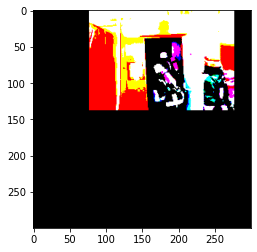

In [200]:
plt.imshow(images[0].permute(1,2,0))

In [206]:
images[0].shape

torch.Size([3, 300, 300])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


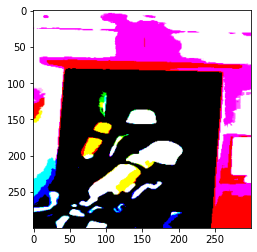

In [203]:
plt.imshow(images2[0].permute(1,2,0))

In [207]:
images2[0].shape

torch.Size([3, 300, 300])

In [1]:
from utils.Firehouse_dataset import *

In [3]:
from utils.transform import  DEFAULT_TRANSFORMS

In [4]:
data = Firehouse_dataset(root = "./" , dataset_type = "VOC" ,yolo_transform = DEFAULT_TRANSFORMS)

In [5]:
data_loader =torch.utils.data.DataLoader(data, batch_size = 1,  # TODO? batch size 
                                  
                                  )

In [6]:
i = iter(data_loader)

In [7]:
next(i)

[('./data/fire/labeled_img/T체r철ffnung und Brandbek채mpfung in der Brand-Simulations-Anlage Goldbach.mp4_1750.jpg',),
 tensor([[[[181, 181, 182,  ..., 251, 251, 251],
           [181, 181, 182,  ..., 251, 251, 251],
           [181, 181, 182,  ..., 251, 251, 251],
           ...,
           [136, 114,  92,  ...,  67,  68,  70],
           [130, 107,  80,  ...,  67,  69,  71],
           [121, 104,  73,  ...,  67,  69,  71]],
 
          [[152, 152, 153,  ..., 255, 255, 255],
           [152, 152, 153,  ..., 255, 255, 255],
           [152, 152, 153,  ..., 255, 255, 255],
           ...,
           [134, 112,  90,  ...,  42,  42,  44],
           [128, 105,  78,  ...,  42,  43,  45],
           [119, 102,  71,  ...,  42,  43,  45]],
 
          [[237, 237, 238,  ..., 255, 255, 255],
           [237, 237, 238,  ..., 255, 255, 255],
           [237, 237, 238,  ..., 255, 255, 255],
           ...,
           [134, 112,  90,  ..., 210, 212, 214],
           [128, 105,  78,  ..., 210, 211, 213